# Compare results with TrajGWAS.jl

+ `TrajGWAS.jl` software: https://github.com/OpenMendel/TrajGWAS.jl


In [1]:
using Revise
using QuasiCopula
using TrajGWAS
using CSV
using Glob
using PrettyTables
using GLM
using LinearAlgebra
using SnpArrays
using Suppressor

using Plots
using MendelPlots
gr(fmt=:png)

ENV["COLUMNS"] = 240
BLAS.set_num_threads(1)
Threads.nthreads()

8

## Hapmap test data

In [2]:
datadir = normpath(joinpath(dirname(pathof(TrajGWAS)), "../data/"))
readdir(glob"*.*", datadir)

14-element Vector{String}:
 "/Users/biona001/.julia/packages/TrajGWAS/R4aGq/data/bgen_snpsetfile.txt"
 "/Users/biona001/.julia/packages/TrajGWAS/R4aGq/data/covariate.txt"
 "/Users/biona001/.julia/packages/TrajGWAS/R4aGq/data/example.8bits.bgen"
 "/Users/biona001/.julia/packages/TrajGWAS/R4aGq/data/example.8bits.bgen.bgi"
 "/Users/biona001/.julia/packages/TrajGWAS/R4aGq/data/hapmap3.bed"
 "/Users/biona001/.julia/packages/TrajGWAS/R4aGq/data/hapmap3.bim"
 "/Users/biona001/.julia/packages/TrajGWAS/R4aGq/data/hapmap3.fam"
 "/Users/biona001/.julia/packages/TrajGWAS/R4aGq/data/hapmap_snpsetfile.txt"
 "/Users/biona001/.julia/packages/TrajGWAS/R4aGq/data/sim_data.jl"
 "/Users/biona001/.julia/packages/TrajGWAS/R4aGq/data/snpsetfile_vcf.txt"
 "/Users/biona001/.julia/packages/TrajGWAS/R4aGq/data/test_vcf.vcf.gz"
 "/Users/biona001/.julia/packages/TrajGWAS/R4aGq/data/trajgwas_bgen_ex.csv"
 "/Users/biona001/.julia/packages/TrajGWAS/R4aGq/data/trajgwas_plinkex.csv"
 "/Users/biona001/.julia/packages/T

## Run TrajGWAS.jl and QuasiCopula.jl

In [27]:
cov_file = joinpath(datadir * "trajgwas_plinkex.csv")
gen_file = joinpath(datadir * "hapmap3") # PLINK file without .bed/bim/fam extensions
c = joinpath(pwd(), "trajgwas.pval.txt")
nullpath = joinpath(pwd(), "trajgwas.null.txt")
pvalpath = "trajgwas.pval.txt"
group_by = :id # rows with the same `group_by` are considered repeated meatures from sample subject

# trajGWAS
@time trajgwas(
    @formula(y ~ 1 + sex + onMeds + snp1 + snp2 + snp3 + snp4), # formula for mean effects
    @formula(y ~ 1),                # formula for random effects
    @formula(y ~ 1 + sex + onMeds), # formula for within-subject variance
    group_by,
    cov_file,
    gen_file,
    pvalfile = pvalpath, # output file for the gwas p-values
    nullfile = nullpath, # output file for the fitted null model
    usespa = false,       # use saddle point approximation or score test
    verbose = false
);

# QuasiCopula GWAS
df = CSV.read(cov_file, DataFrame)
y = :y
d = Normal()
link = IdentityLink()
covariates = [:sex, :onMeds, :snp1, :snp2, :snp3, :snp4]
qc_model = VC_model(df, y, group_by, covariates, d, link)
@suppress QuasiCopula.fit!(qc_model)
G = SnpData(gen_file)
@time qc_pvals = QuasiCopula.GWASCopulaVCModel(qc_model, G.snparray, check_grad=true);
# @time qc_pvals_true = QuasiCopula.GWASCopulaVCModel_autodiff_fast(qc_model, G.snparray, check_grad=true);

# compare p-values
trajGWAS_result = CSV.read(pvalpath, DataFrame)
[qc_pvals qc_pvals_true trajGWAS_result[!, "betapval"]]

run = 1, ‖Δβ‖ = 0.039033, ‖Δτ‖ = 0.320815, ‖ΔL‖ = 0.002056, status = LOCALLY_SOLVED, time(s) = 0.018905
run = 2, ‖Δβ‖ = 0.005078, ‖Δτ‖ = 0.047483, ‖ΔL‖ = 0.004220, status = LOCALLY_SOLVED, time(s) = 0.017903
  0.329713 seconds (1.36 M allocations: 127.858 MiB, 25.52% gc time, 0.96% compilation time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Wtime = 0.5410431780000001
Qtime = 0.3239315268750004
Rtime = 0.17793289875000048
grad_res_time = 0.05201650425000001
othertime = 0.02923326649999996
scoretest_time = 0.001231535499999991
  1.240933 seconds (27.63 M allocations: 1.492 GiB, 10.79% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:15


grad time = 1.9352482380000062
hess time = 13.57208718100003
 15.609991 seconds (10.42 M allocations: 1.801 GiB, 0.50% gc time)


13928×3 Matrix{Float64}:
 NaN           NaN            1.0
   0.419156      0.419156     0.689825
   0.00215945    0.00215945   0.915347
   5.88632e-8    5.88632e-8   0.539575
   1.0           1.40301e-14  1.0
 NaN           NaN            1.0
   0.729412      0.729412     0.145089
   0.814898      0.814898     0.2367
   5.62857e-7    5.62857e-7   0.147444
   0.865469      0.865469     0.914766
 NaN           NaN            1.0
   0.536554      0.536554     0.647976
   0.00238035    0.00238035   0.143678
   ⋮                          
   0.0467218     0.0467218    0.996963
   0.065946      0.065946     0.976543
   0.0902895     0.0902895    0.912266
   0.0782109     0.0782109    0.979217
   0.105738      0.105738     0.92517
   0.00449954    0.00449954   0.596064
   0.0924861     0.0924861    0.959083
   0.0982547     0.0982547    0.914567
   0.0928458     0.0928458    0.93992
   0.628908      0.628908     0.318731
   0.698285      0.698285     0.911726
   0.221815      0.221815     0.

## QQ plots

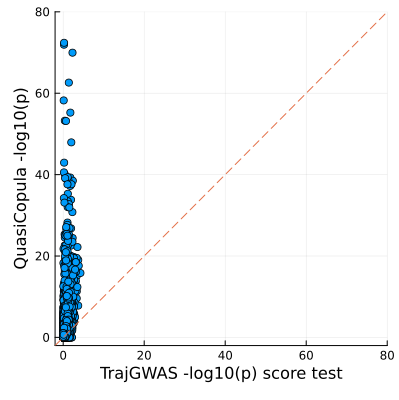

In [29]:
# compare -log10(p-values)
success_idx = findall(!isnan, qc_pvals)
scatter(
    -log10.(trajGWAS_result[success_idx, "betapval"]),
    -log10.(qc_pvals[success_idx]), 
    xlabel = "TrajGWAS -log10(p) score test",
    ylabel = "QuasiCopula -log10(p)",
    label=false,
    size=(400, 400),
    xlim=(-2, 80),
    ylim=(-2, 80),
)
Plots.abline!(1, 0, line=:dash, label=false)

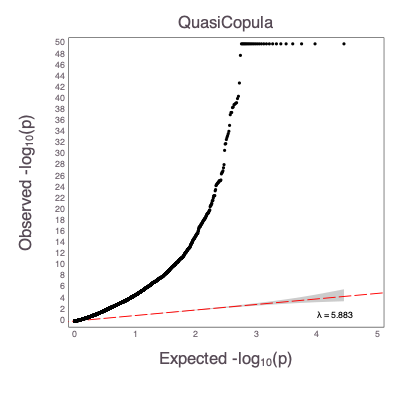

In [25]:
using MendelPlots
idx = findall(!isnan, qc_pvals)
success_pvals = qc_pvals[idx]
idx2 = findall(x -> x < 1e-50, success_pvals)
success_pvals[idx2] .= 1e-50
qq(success_pvals, dpi=80, titles="QuasiCopula")
display("image/png", read("qqplot.png"))

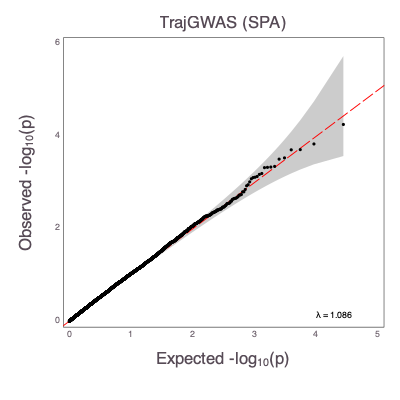

In [28]:
using MendelPlots
idx = findall(!isone, trajGWAS_result[!, "betapval"])
qq(trajGWAS_result[idx, "betapval"], dpi=80, titles="TrajGWAS (SPA)")
display("image/png", read("qqplot.png"))